## Ансамбль моделей

В этом ноутбуке мы попробуем объеденить наши лучшие модели в ансамбль. Мы будем использовать ансамбль из 3 моделей:

* SVC - модель, которая показала лучшее качество среди линейных моделей
* TimeSeries - модель, которая использовала классические подходы для временных рядов
* KNN - модель, которая показала лучшее качество среди нелинейных моделей

In [10]:
import re
import nltk
import os
import sys
import pandas as pd

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
from pymystem3 import Mystem

import warnings

warnings.filterwarnings("ignore")

# Добавляем в path вышестоящую директорию для импорта  calc_metrics
sys.path.append(os.path.abspath(os.path.join("..")))

from utils import calc_metrics, PrefitTransformer

RANDOM_STATE = 41825352
DATASET_URL = "https://storage.yandexcloud.net/cbr-press-release-classifier/cbr-press-releases.csv"

nltk.download("stopwords", quiet=True);

Получаем данные

In [11]:
# загружаем данные из s3
df = pd.read_csv(DATASET_URL, parse_dates=["date"])

# устанавливаем дату релиза как индекс
df.set_index("date", inplace=True)
df.sort_values("date", inplace=True)

# сдвигаем величину ставки, чтобы избежать лика данных
df['rate'] = df['rate'].shift(1)

# разделяем данные на признаки и целевую переменную
X = df[["release", "inflation", "rate", "usd"]]
y = df["target_categorial"]

Определим функцию для предобработки текстов

In [12]:
# загружаем стоп-слова
STOP_WORDS = set(stopwords.words("russian"))

# инициализируем лемматизатор
mystem = Mystem()

# функция для препроцессинга текста
def preprocessor(text):
    # нижний регистр
    text = text.lower()
    # удаляем все символы, кроме русских букв и пробелов
    regex = re.compile("[^а-я А-ЯЁё]")
    text = regex.sub(" ", text)
    # лемматизация
    text = " ".join(mystem.lemmatize(text))
    # удаляем стоп-слова
    text = " ".join([word for word in text.split() if word not in STOP_WORDS])
    return text

Генерация новых признаков, для модели которая использует подход временных рядов

In [13]:
# список экзогенных признаков
timeseries_features = ["inflation", "rate", "usd"]

# список лагов целевой переменной
target_lags = [f"lag{i}_target" for i in range(5)]

# добавляем лаги целевой переменной
for i in range(1, 4 + 1):
    X[f"lag{i}_target"] = y.shift(i)

# для всех экзогенных признаков
for feature in ["inflation", "rate", "usd"]:
    # добавляем рост
    X[f"growth_{feature}"] = X[feature] / X[feature].shift(1)
    timeseries_features.append(f"growth_{feature}")

copy_timeseries_features = timeseries_features.copy()

# для всех признаков добавляем лаги
for feature in copy_timeseries_features:
    for i in range(1, 4):
        X[f"lag{i}_{feature}"] = X[feature].shift(i)
        timeseries_features.append(f"lag{i}_{feature}")

# заполняем пропуски следующими значениями
X.bfill(inplace=True)
X.ffill(inplace=True)

# исключаем последний релиз
last_release = X.tail(1)

X = X[:-1]
y = y[:-1]

Определяем пайплайн

In [14]:
# Метод опорных векторов лучшая модель среди линейных

# векторизация пресс-релизов для SVC
preprocessor_svc = ColumnTransformer(
    [
        (
            "tf-idf",
            TfidfVectorizer(
                preprocessor=preprocessor, min_df=10, max_df=0.9758183335731473
            ),
            0,
        )
    ]
)

# Обучение tf-idf на всех данных
preprocessor_svc = PrefitTransformer(preprocessor_svc.fit(X.values))

# модель для отбора признаков
selector_svc = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    C=422.71537816231074,
    max_iter=1000,
    random_state=RANDOM_STATE,
)

# объеденяем tf-idf, модель для отбора признаков и SVC в пайплайн.
svc = Pipeline(
    [
        ("transform", preprocessor_svc),
        ("selector", SelectFromModel(selector_svc)),
        (
            "classifier",
            SVC(
                C=18.354988739710503,
                kernel="rbf",
                probability=True,
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

# TimeSeries модель

# масштабируем лаговые и экзогенные признаки
preprocessor_timeseries = ColumnTransformer(
    transformers=[("scaler", StandardScaler(), list(range(1, X.shape[1])))]
)

# объеденяем масштабирование и KNN в пайплайн
timeseries = Pipeline(
    steps=[
        ("preprocessor", preprocessor_timeseries),
        (
            "classifier",
            KNeighborsClassifier(
                n_neighbors=2,
                weights="distance",
                p=1,
                algorithm="brute",
            ),
        ),
    ]
)

# KNN модель на пресс-релизах

# векторизация пресс-релизов для KNN
preprocessor_knn = ColumnTransformer(
    [
        (
            "tf-idf",
            TfidfVectorizer(
                preprocessor=preprocessor, min_df=9, max_df=0.9450766977518593
            ),
            0,
        )
    ]
)

# обучаем tf-idf на всех данных
preprocessor_knn = PrefitTransformer(preprocessor_knn.fit(X.values))

# модель для отбора признаков
selector_knn = LogisticRegression(
    penalty="l1",
    solver="liblinear",
    C=435.61061540050844,
    max_iter=1000,
    random_state=RANDOM_STATE,
)

# объеденяем tf-idf, модель для отбора признаков и KNN в пайплайн
knn = Pipeline(
    steps=[
        ("preprocessor", preprocessor_knn),
        ("selector", SelectFromModel(selector_knn, max_features=659)),
        (
            "classifier",
            KNeighborsClassifier(
                n_neighbors=2,
                weights="distance",
                p=1.6745446714251242,
                metric="cosine",
                algorithm="brute",
            ),
        ),
    ]
)

# Создаем ансамбль моделей методом голосования
ensemble = VotingClassifier(
    estimators=[
        ("svc", svc),
        ("timeseries", timeseries),
        ("knn", knn),
    ],
    voting="soft", # возвращаем вероятности классов
)

In [15]:
ensemble

VotingClassifier(estimators=[('svc',
                              Pipeline(steps=[('transform',
                                               PrefitTransformer(transformer=b'\x80\x04\x95\x8a'
                                                                             b'T\x00\x00\x00'
                                                                             b'\x00\x00\x00\x8c'
                                                                             b'#skl'
                                                                             b'earn'
                                                                             b'.com'
                                                                             b'pose'
                                                                             b'._co'
                                                                             b'lumn'
                                                                             b'_tra'
                                                                             b'nsfo'
                                                                             b'rmer'
                                                                             b'\x94\x8c\x11C'
                                                                             b'olum'
                                                                             b'nTra'
                                                                             b'nsfo'
                                                                             b'rmer'
                                                                             b'\x94\x93\x94)'
                                                                             b'\x81\x94}\x94'
                                                                             b'(\x8c\x0ct'
                                                                             b'rans'
                                                                             b'form'
                                                                             b'ers\x94'
                                                                             b']\x94\x8c\x06'
                                                                             b'tf-i'
                                                                             b'...
                                                                             b'K\x00N\x87'
                                                                             b'\x94R\x94u'
                                                                             b'h.h/'
                                                                             b'ub.')),
                                              ('selector',
                                               SelectFromModel(estimator=LogisticRegression(C=435.61061540050844,
                                                                                            max_iter=1000,
                                                                                            penalty='l1',
                                                                                            random_state=41825352,
                                                                                            solver='liblinear'),
                                                               max_features=659)),
                                              ('classifier',
                                               KNeighborsClassifier(algorithm='brute',
                                                                    metric='cosine',
                                                                    n_neighbors=2,
                                                                    p=1.6745446714251242,
                                                                    weights='distance'))]))],
                 voting='soft')

Посмотрим насколько хорошо работает наш классификатор с помощью кросс-валидации

              precision    recall  f1-score   support

        -1.0       0.80      0.87      0.83        23
         0.0       0.69      0.64      0.67        28
         1.0       0.74      0.74      0.74        19

    accuracy                           0.74        70
   macro avg       0.74      0.75      0.75        70
weighted avg       0.74      0.74      0.74        70



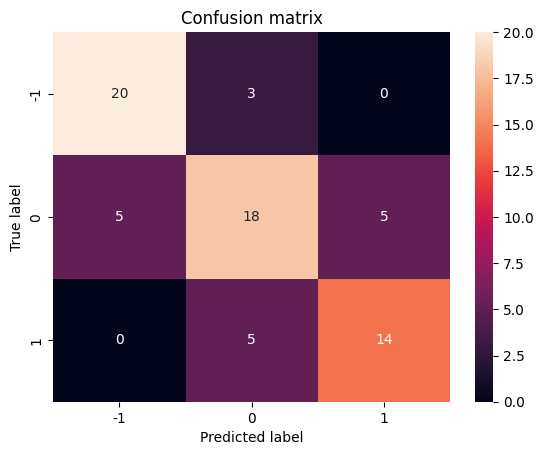

In [16]:
metrics, model = calc_metrics(X.values, y, ensemble, name="ensemble")

In [17]:
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
ensemble,0.742857,0.745614,0.749755,0.74305,0.844431,0.849624


В результате применения метода обычного голосования наша метрика подросла и достигла значения 0.8496. В процессе выбора лучших моделей для голосования, было замечено, что помимо `roc_auc_ovo`, также стоит учитывать `accuracy`. `Accuracy` будет показывать насколько хорошо будет выглядеть матрица ошибок. `roc_auc_ovo` - это среднее значение `roc_auc` между всеми парами классов, в нашем случае таких пар 3. На одной паре (-1 и 1) такая метрика будет равна 1, так как модель не путает повышение и понижение ставки, а как мы знаем высокое значение всегда смещает среднее в свою сторону, поэтому `roc_auc_ovo` будет немного завышена.

Сделаем предсказание о динамике ключевой ставки на следующем заседании ЦБ:

In [18]:
ensemble.fit(X, y)
print(ensemble.predict(last_release))
print(ensemble.predict_proba(last_release))

[0.]
[[0.02428786 0.79425094 0.18146121]]


Модель предсказывает, что на следующем заседании ставка не изменится с вероятностью 0.794.